*This is from the IBM Tutorial. Mainly adding some of my notes in this notebook.*

*Estimated QPU usage: 73 minutes (tested on IBM Kyiv)*

## Background

[Variational quantum algorithms](https://arxiv.org/abs/2012.09265) are promising candidate hybrid-algorithms for observing quantum computation utility on noisy near-term devices. Variational algorithms are characterized by the use of a classical optimization algorithm to iteratively update a parameterized trial solution, or "ansatz". Chief among these methods is the Variational Quantum Eigensolver (VQE) that aims to solve for the ground state of a given Hamiltonian represented as a linear combination of Pauli terms, with an ansatz circuit where the number of parameters to optimize over is polynomial in the number of qubits.  Given that the size of the full solution vector is exponential in the number of qubits, successful minimization using VQE requires, in general, additional problem-specific information to define the structure of the ansatz circuit.

Executing a VQE algorithm requires the following components:

1. Hamiltonian and ansatz (problem specification)
2. Qiskit Runtime estimator
3. Classical optimizer

Although the Hamiltonian and ansatz require domain-specific knowledge to construct, these details are immaterial to the Runtime, and we can execute a wide class of VQE problems in the same manner.


### **Note 1 (by Umi)**:

*VQA (Variational Quantum Algorithms) use classical optimization algorithm to iteratively update and refine a parameterized trial solution (ansatz) These algorithms help to demonstrate the potential utility of quantum computation on noisy devices.*

*From many methods of VQA, a popular one is VQE (Variational Quantum Eigensolver). It aims to find the ground state energy of a Hamiltonian using an ansatz circuit, where the number of parameters to optimize scales polynomially with the number of qubits. If the scaling were exponential in the number of qubits, the VQE would require significantly more computational resources.*  

*The step to run a VQE needs:*
1. Define Hamiltonian and an ansatz (parameterized trial solution)
2. Use runtime estimator to evaluate the energy based on the given parameters.
3. Employ classical optimizer to iteratively update and refine a solution

## Requirements

Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later, with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime 0.22 or later(`pip install qiskit-ibm-runtime`)


In [ ]:
!pip install 'qiskit[visualization]'
!pip install qiskit-ibm-runtime

## Step 1. Map classical inputs to a quantum problem

Although the problem instance in question for the VQE algorithm can come from a variety of domains, the form for execution through Qiskit Runtime is the same. Qiskit provides a convenience class for expressing Hamiltonians in Pauli form, and a collection of widely used ansatz circuits in the [`qiskit.circuit.library`](https://docs.quantum-computing.ibm.com/api/qiskit/circuit_library).

This example Hamiltonian is derived from a quantum chemistry problem.


### **Note 2 (by Umi)**:

qiskit.circuit.library includes EfficientSU2, a pre-defined ansatz circuit.

It is often used in combination with a Hamiltonian in variational quantum algorithms like VQE to approximate the ground state.

### Setup

Here we import the tools needed for a VQE experiment.


In [ ]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp # Creating for Hamiltonian Operator

# SciPy minimizer routine
from scipy.optimize import minimize # Classical Optimization Algorithms

# Plotting functions
import matplotlib.pyplot as plt

In [ ]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session # QiskitRuntimeService is for accesing the IBM Service (Hardware). Session is for helping executing quantum program (job)
from qiskit_ibm_runtime import EstimatorV2 as Estimator # EstimatorV2 is to use runtime estimator to evaluate the energy.

# To run on hardware, select the backend with the fewest number of jobs in the queue
# We will put the Token to run the service. To get a Token please sign up the IBM Quantum Platform.
# Save your API token
QiskitRuntimeService.save_account(channel="ibm_quantum", token="547295db57b72956611792fdf526bf5c0b3d2c8fbb5acbd6424973381d4dd2430187393b4fcf35c3374e778890347aa4c21b2c1f47d98e905eda8e461da6109b", overwrite = True)

service = QiskitRuntimeService(channel="ibm_quantum") # Access to the IBM Hardware
backend = service.least_busy(operational=True, simulator=False) # It helps to find the least busy IBM Hardware

In [ ]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
) # Define Hamiltonian Operator

# What those YZ stuff represents? -> It shows the how qubits interact to it.

# For example, first term show that pauli Y acts on first qubits and pauli Z acts on second qubits.
# This is also similar to other 3 terms

# What is number represents like 0.3980? -> It represents the coefficient or specifically name as weight.
# How to find that specific number? -> Probably based on the experiment (quantum chemistry) or simulation.

Our choice of ansatz is the `EfficientSU2` that, by default, linearly entangles qubits, making it ideal for quantum hardware with limited connectivity.


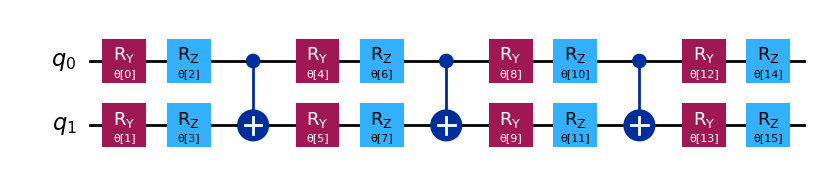

In [16]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
# Define ansatz circuits based on number of qubits that is used in hamiltonian operator. In this case there are two qubits.
# What does EfficientSU2 do? -> Based on the number of qubits, it will make an ideal circuit that could helps to find the ground state of the Hamiltonian.

ansatz.decompose().draw("mpl", style="iqp")
# It will draw the ansatz circuits.
# What is decompose() do? -> it will decompose the ansatz circuit into fundamental gates for better visualization.
# "mpl" -> Means draw by using matplotlib
# "iqp" -> Specific visualize theme

From the previous figure we see that our ansatz circuit is defined by a vector of parameters, $\theta_{i}$, with the total number given by:


In [17]:
num_params = ansatz.num_parameters
num_params
# Calculate the number of parameters

# What is parameters mean? -> It refers to number of the variables used in parameterized gates (e.g. R_y, R_z)
# How to calculate the number of parameters? -> Just count how many gates by looking visually! OR 2 qubits * 8 gates per layer * 1 repetition = 16 parameters!

16

## Step 2. Optimize problem for quantum execution


To reduce the total job execution time, Qiskit primitives only accept circuits (ansatz) and observables (Hamiltonian) that conform to the instructions and connectivity supported by the target QPU (referred to as instruction set architecture (ISA) circuits and observables).


### **Note 3 (by Umi)**:

In most programming tasks, we aim for efficient execution. While Python isn't particularly fast, Qiskit compensates by implementing smart optimizations. It analyzes the ansatz and Hamiltonian operator to ensure the code only processes the necessary components. You can think of the ansatz and Hamiltonian as a recipe guiding the computation. Thanks, IBM!

### ISA circuit


Schedule a series of [`qiskit.transpiler`](https://docs.quantum-computing.ibm.com/api/qiskit/transpiler) passes to optimize the circuit for a selected backend and make it compatible with the backend's ISA. This can be easily done with a preset pass manager from `qiskit.transpiler` and its `optimization_level` parameter.

The lowest optimization level does the minimum needed to get the circuit running on the device; it maps the circuit qubits to the device qubits and adds swap gates to allow all two-qubit operations. The highest optimization level is much smarter and uses lots of tricks to reduce the overall gate count. Since multi-qubit gates have high error rates and qubits decohere over time, the shorter circuits should give better results.


### **Note 4 (by Umi)**:

Based on the selected least busy hardware, Qiskit's transpiler helps to optimize the quantum circuit for that specific device.

The level of optimization level varies how fast and tricks to reduce the gate count.

In our case, we have multi-qubit gates so we have high error rates and decohere over time so it will be better to have a shorter circuits and it gives better results.

In [19]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# import the Qiskit transpiler


target = backend.target # select the hardware that we used previously.
pm = generate_preset_pass_manager(target=target, optimization_level=3)
# before running, setting up the optimization based on the hardware(target) and level of optimization.

ansatz_isa = pm.run(ansatz)
# Generate.

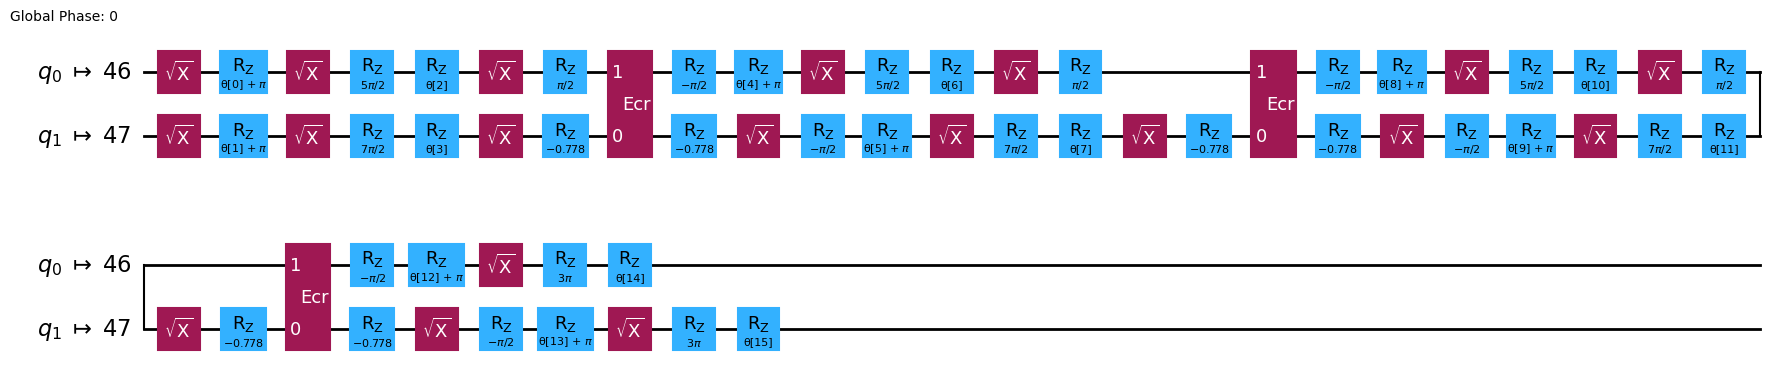

In [23]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")
# Draw the optimize version

# idle_wires -> hide all the wires that have no operations.
# Don't try to make it True! It will cause a long runtime, which I did and regretted

### ISA observable


Transform the Hamiltonian to make it backend-compatible before running jobs with [`Runtime Estimator V2`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2#run). Perform the transformation by using the `apply_layout` method of `SparsePauliOp` object.


In [24]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)
# Apply the optimized layout of the ansatz circuit to the Hamiltonian operator.
# This ensures the Hamiltonian is transformed to align with the optimized circuit layout.

## Step 3. Execute using Qiskit Primitives

Like many classical optimization problems, the solution to a VQE problem can be formulated as minimization of a scalar cost function.  By definition, VQE looks to find the ground state solution to a Hamiltonian by optimizing the ansatz circuit parameters to minimize the expectation value (energy) of the Hamiltonian.  With the Qiskit Runtime [`Estimator`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) directly taking a Hamiltonian and parameterized ansatz, and returning the necessary energy, the cost function for a VQE instance is quite simple.

Note that the `run()` method of [Qiskit Runtime `EstimatorV2`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2)  takes an iterable of `primitive unified blocs (PUBs)`. Each PUB is an iterable in the format `(circuit, observables, parameter_values: Optional, precision: Optional)`.


In [ ]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

Note that, in addition to the array of optimization parameters that must be the first argument, we use additional arguments to pass the terms needed in the cost function, such as the `cost_history_dict`. This dictionary stores the current vector at each iteration, for example in case you need to restart the routine due to failure, and also returns the current iteration number and average time per iteration.


In [ ]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

We can now use a classical optimizer of our choice to minimize the cost function. Here, we use the [COBYLA routine from SciPy through the `minimize` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). Note that when running on real quantum hardware, the choice of optimizer is important, as not all optimizers handle noisy cost function landscapes equally well.

To begin the routine, specify a random initial set of parameters:


In [ ]:
x0 = 2 * np.pi * np.random.random(num_params)

In [ ]:
x0

array([2.51632747, 0.41779892, 5.85800259, 4.83749838, 3.20828874,
       5.23058321, 0.23909191, 5.93347588, 0.98307886, 5.8564212 ,
       3.41519817, 2.07444879, 0.7790487 , 0.72421971, 1.09848722,
       3.31663941])

Because we are sending a large number of jobs that we would like to execute together, we use a [`Session`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Session) to execute all the generated circuits in one block.  Here `args` is the standard SciPy way to supply the additional parameters needed by the cost function.


In [ ]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: -0.41297466987766457]
Iters. done: 2 [Current cost: -0.4074417945791059]
Iters. done: 3 [Current cost: -0.3547606824167446]
Iters. done: 4 [Current cost: -0.28168907720107683]
Iters. done: 5 [Current cost: -0.4578159863650208]
Iters. done: 6 [Current cost: -0.3086594190935841]
Iters. done: 7 [Current cost: -0.15483382641187454]
Iters. done: 8 [Current cost: -0.5349854031388536]
Iters. done: 9 [Current cost: -0.3895567829431972]
Iters. done: 10 [Current cost: -0.4820250378135054]
Iters. done: 11 [Current cost: -0.18395917730188865]
Iters. done: 12 [Current cost: -0.5311791591751455]
Iters. done: 13 [Current cost: -0.49602925858832053]
Iters. done: 14 [Current cost: -0.3482916173440449]
Iters. done: 15 [Current cost: -0.5668230348151325]
Iters. done: 16 [Current cost: -0.521882967057639]
Iters. done: 17 [Current cost: -0.26976382760304113]
Iters. done: 18 [Current cost: -0.051127606468041646]
Iters. done: 19 [Current cost: -0.5213490424900524]
Iters. done: 2

At the terminus of this routine we have a result in the standard SciPy `OptimizeResult` format.  From this we see that it took `nfev` number of cost function evaluations to obtain the solution vector of parameter angles (`x`) that, when plugged into the ansatz circuit, yield the approximate ground state solution we were looking for.


In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.634701203143904
       x: [ 2.581e+00  4.153e-01 ...  1.070e+00  3.123e+00]
    nfev: 146
   maxcv: 0.0

## Step 4. Post-process, return result in classical format


If the procedure terminates correctly, then the `prev_vector` and `iters` values in our `cost_history_dict` dictionary should be equal to the solution vector and total number of function evaluations, respectively.  This is easy to verify:


In [ ]:
all(cost_history_dict["prev_vector"] == res.x)

True

In [ ]:
cost_history_dict["iters"] == res.nfev

False

We can also now view the progress toward convergence as monitored by the cost history at each iteration:


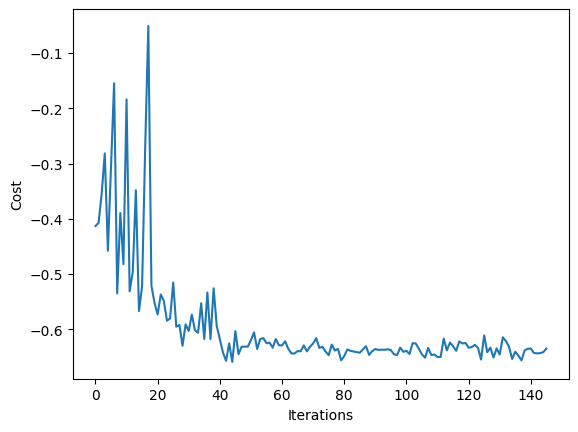

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

## Tutorial Survey

<table style="width: 100%;">
<tbody>
<tr>
<td style="width: 10%;"><img src="https://learning-api.quantum.ibm.com/assets/53171443-b07b-4ae6-a4be-9aec32a854f5" alt="Survey" width="100%" height="100%"></td>
<td style="width: 80%;"><strong><a title="Tutorial Survey" href="https://your.feedback.ibm.com/jfe/form/SV_9AizRyKFHEGzVs2" target="_blank">Tutorial Survey</a></strong><br>Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.</td>
</tr>
</tbody>
</table>
